In [38]:
import torch
from torch import nn
from torch.optim.lr_scheduler import (
    ExponentialLR,
    CosineAnnealingLR,
    CyclicLR,
    MultiStepLR,
    ReduceLROnPlateau,
)
import sys, os
import tqdm
import matplotlib.pyplot as plt

sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname("src"))))
from src.CumstomCosineAnnealingwarmRestarts import CosineAnnealingWarmUpRestarts
from src.Mydataloader import LoadDataset
from src.Mymodel import MyResNet_CIFAR
from src.Earlystopper import EarlyStopper
from src.LogViewer import LogViewer

In [39]:
"""Dataset selection"""
DATASET = "CIFAR10"
# DATASET = "CIFAR100"
# DATASET = "ImageNet2012"

"""Dataset parameters"""
BATCH = 128
SHUFFLE = True
NUMOFWORKERS = 8
PIN_MEMORY = True

"""optimizer parameters"""
optim_list = [
    # "Adam",
    # "Adam_decay",
    "SGD",
    # "SGD_nasterov",
    # "AdamW",
    # "AdamW_amsgrad",
    "NAdam",
]
print_pad_len_optim = max([len(i) for i in optim_list])

scheduler_list = [
    "ExponentialLR",
    "MultiStepLR",
    "ReduceLROnPlateau",
    "CosineAnnealingLR",
    "CosineAnnealingWarmUpRestarts",
    # "CycleLR",
]
print_pad_len_schduler = max([len(i) for i in scheduler_list])

"""Learning rate scheduler parameters"""
NUM_EPOCHS = 100

"""Early stopping parameters"""
EARLYSTOPPINGPATIENCE = NUM_EPOCHS

In [40]:
class Single_model:
    def __init__(self, optimizer_name, schduler_name, device="cuda") -> None:
        self.file_name = f"MyResNet32_{BATCH}_{optimizer_name}_{schduler_name}"
        self.optim_name = optimizer_name
        self.scheduler_name = schduler_name
        """define model"""
        self.model = MyResNet_CIFAR(
            num_classes=10, num_layer_factor=5
        ).to(device)

        """define loss function"""
        self.criterion = nn.CrossEntropyLoss()

        """define optimizer"""
        if optimizer_name == "Adam":
            self.optimizer = torch.optim.Adam(self.model.parameters())
        elif optimizer_name == "Adam_decay":
            self.optimizer = torch.optim.Adam(
                self.model.parameters(), weight_decay=1e-4
            )
        elif optimizer_name == "SGD":
            self.optimizer = torch.optim.SGD(
                self.model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4
            )
        elif optimizer_name == "SGD_nasterov":
            self.optimizer = torch.optim.SGD(
                self.model.parameters(),
                lr=0.1,
                momentum=0.9,
                weight_decay=1e-4,
                nesterov=True,
            )
        elif optimizer_name == "AdamW":
            self.optimizer = torch.optim.AdamW(
                self.model.parameters(), weight_decay=1e-4
            )
        elif optimizer_name == "AdamW_amsgrad":
            self.optimizer = torch.optim.AdamW(
                self.model.parameters(), weight_decay=1e-4, amsgrad=True
            )
        elif optimizer_name == "NAdam":
            self.optimizer = torch.optim.NAdam(
                self.model.parameters(), weight_decay=1e-4
            )

        """define earlystopper"""
        self.earlystopper = EarlyStopper(
            patience=EARLYSTOPPINGPATIENCE, model=self.model, file_name=self.file_name
        )

        """define learning rate scheduler"""
        if schduler_name == "ExponentialLR":
            self.scheduler = ExponentialLR(self.optimizer, gamma=0.95)
        elif schduler_name == "MultiStepLR":
            self.scheduler = MultiStepLR(self.optimizer, milestones=[50, 75], gamma=0.1)
        elif schduler_name == "ReduceLROnPlateau":
            self.scheduler = ReduceLROnPlateau(
                self.optimizer, patience=10, factor=0.1, cooldown=40
            )
        elif schduler_name == "CosineAnnealingLR":
            """
            - T_max : half of single pariod
            - eta_min : min_lr
            """
            self.scheduler = CosineAnnealingLR(self.optimizer, T_max=20, eta_min=0.001)
        elif schduler_name == "CosineAnnealingWarmUpRestarts":
            """
            초기 lr = near zero여야함.
            - T_0 : single period,
            - T_mult : period multiply factor. 2면 다음부터 주기 2배욈
            - eta_max : max_lr. 처음 튀어 오를 lr
            - T_up : warmup period. 튀어오르는데 필요한 epochs.
            - gamma : eta_max decay factor.
            """

            self.scheduler = CosineAnnealingWarmUpRestarts(
                self.optimizer, T_0=10, T_mult=1, eta_max=0.1, T_up=2, gamma=0.5
            )

        # elif schduler == "CycleLR":
        #     self.scheduler = CyclicLR(
        #         self.optimizer,
        #         base_lr=0.001,
        #         max_lr=0.1,
        #         step_size_up=50,
        #         step_size_down=None,
        #         mode="triangular2",
        #     )

        """define scaler"""
        self.scaler = torch.cuda.amp.GradScaler(enabled=True)


# %%
class Single_training(Single_model):
    def __init__(self, optimizer_name, schduler_name, device="cuda"):
        super().__init__(
            optimizer_name=optimizer_name, schduler_name=schduler_name, device=device
        )

        self.device = device
        """loading log file"""
        if os.path.exists(self.file_name + ".pth.tar"):
            # Read checkpoint as desired, e.g.,
            checkpoint = torch.load(
                self.file_name + ".pth.tar",
                map_location=lambda storage, loc: storage.cuda(self.device),
            )
            self.model.load_state_dict(checkpoint["model"])
            self.optimizer.load_state_dict(checkpoint["optimizer"])
            self.scaler.load_state_dict(checkpoint["scaler"])
            self.scheduler.load_state_dict(checkpoint["scheduler"])
            self.earlystopper.load_state_dict(checkpoint["earlystopper"])
            self.logs = checkpoint["logs"]

            print("Suceessfully loaded the All setting and Log file.")
            print(self.file_name)
            print(f"Current epoch is {len(self.logs['train_loss'])}")
            print(f"Current learning rate: {self.optimizer.param_groups[0]['lr']}")
        else:
            # Create a dictionary to store the variables
            train_loss = []
            train_acc = []
            eval_loss = []
            valid_acc = []
            test_loss = []
            test_acc = []
            lr_log = []
            self.logs = {
                "train_loss": train_loss,
                "train_acc": train_acc,
                "valid_loss": eval_loss,
                "valid_acc": valid_acc,
                "test_loss": test_loss,
                "test_acc": test_acc,
                "lr_log": lr_log,
            }
            print("File does not exist. Created a new log.")

        self.train_loss = 0.0
        self.running_loss = 0.0
        self.running_corrects = 0
        self.running_total = 0
        self.train_acc = 0

        self.test_loss = 0.0
        self.test_corrects = 0
        self.test_total = 0
        self.test_acc = 0.0

    def set_mode_train(self):
        self.running_loss = 0.0
        self.running_corrects = 0
        self.running_total = 0
        self.model.train()

    def set_mode_test(self):
        self.test_loss = 0.0
        self.test_corrects = 0
        self.test_total = 0
        self.model.eval()

In [41]:
each_trainings = list()
for optim_name in optim_list:
    for schduler_name in scheduler_list:
        each_trainings.append(
            Single_training(
                optimizer_name=optim_name, schduler_name=schduler_name, device="cuda"
            )
        )

        if schduler_name == "CosineAnnealingWarmUpRestarts":
            each_trainings[-1].optimizer.param_groups[0]["lr"] = 1e-8
            if optim_name == "NAdam":
                each_trainings[-1].scheduler.eta_max *= 2

Suceessfully loaded the All setting and Log file.
MyResNet32_128_SGD_ExponentialLR
Current epoch is 100
Current learning rate: 0.0005920529220333994
Suceessfully loaded the All setting and Log file.
MyResNet32_128_SGD_MultiStepLR
Current epoch is 100
Current learning rate: 0.0010000000000000002
Suceessfully loaded the All setting and Log file.
MyResNet32_128_SGD_ReduceLROnPlateau
Current epoch is 100
Current learning rate: 0.1
Suceessfully loaded the All setting and Log file.
MyResNet32_128_SGD_CosineAnnealingLR
Current epoch is 100
Current learning rate: 0.001
Suceessfully loaded the All setting and Log file.
MyResNet32_128_SGD_CosineAnnealingWarmUpRestarts
Current epoch is 100
Current learning rate: 0.012287036584677545
Suceessfully loaded the All setting and Log file.
MyResNet32_128_NAdam_ExponentialLR
Current epoch is 100
Current learning rate: 1.1841058440667989e-05
Suceessfully loaded the All setting and Log file.
MyResNet32_128_NAdam_MultiStepLR
Current epoch is 100
Current lear

90
0.3227151705871654
SGD CosineAnnealingWarmUpRestarts 2.0807833321894966
88
0.2790281892388682
NAdam CosineAnnealingWarmUpRestarts 0.04161612271002235


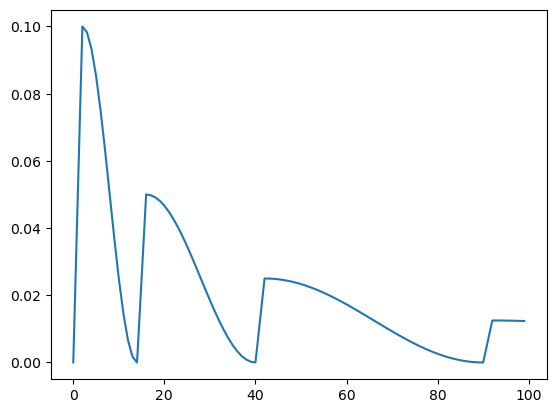

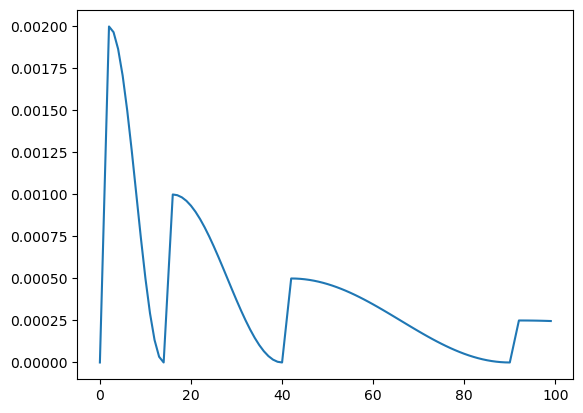

In [42]:
import numpy as np

for dja in each_trainings:
    if dja.scheduler_name == "CosineAnnealingWarmUpRestarts":
        fig, ax = plt.subplots()
        ax.plot(dja.logs["lr_log"])
        print(np.argmin(dja.logs["test_loss"]))
        print(np.min(dja.logs["test_loss"]))
        print(dja.optim_name, dja.scheduler_name, np.sum(dja.logs["lr_log"]))

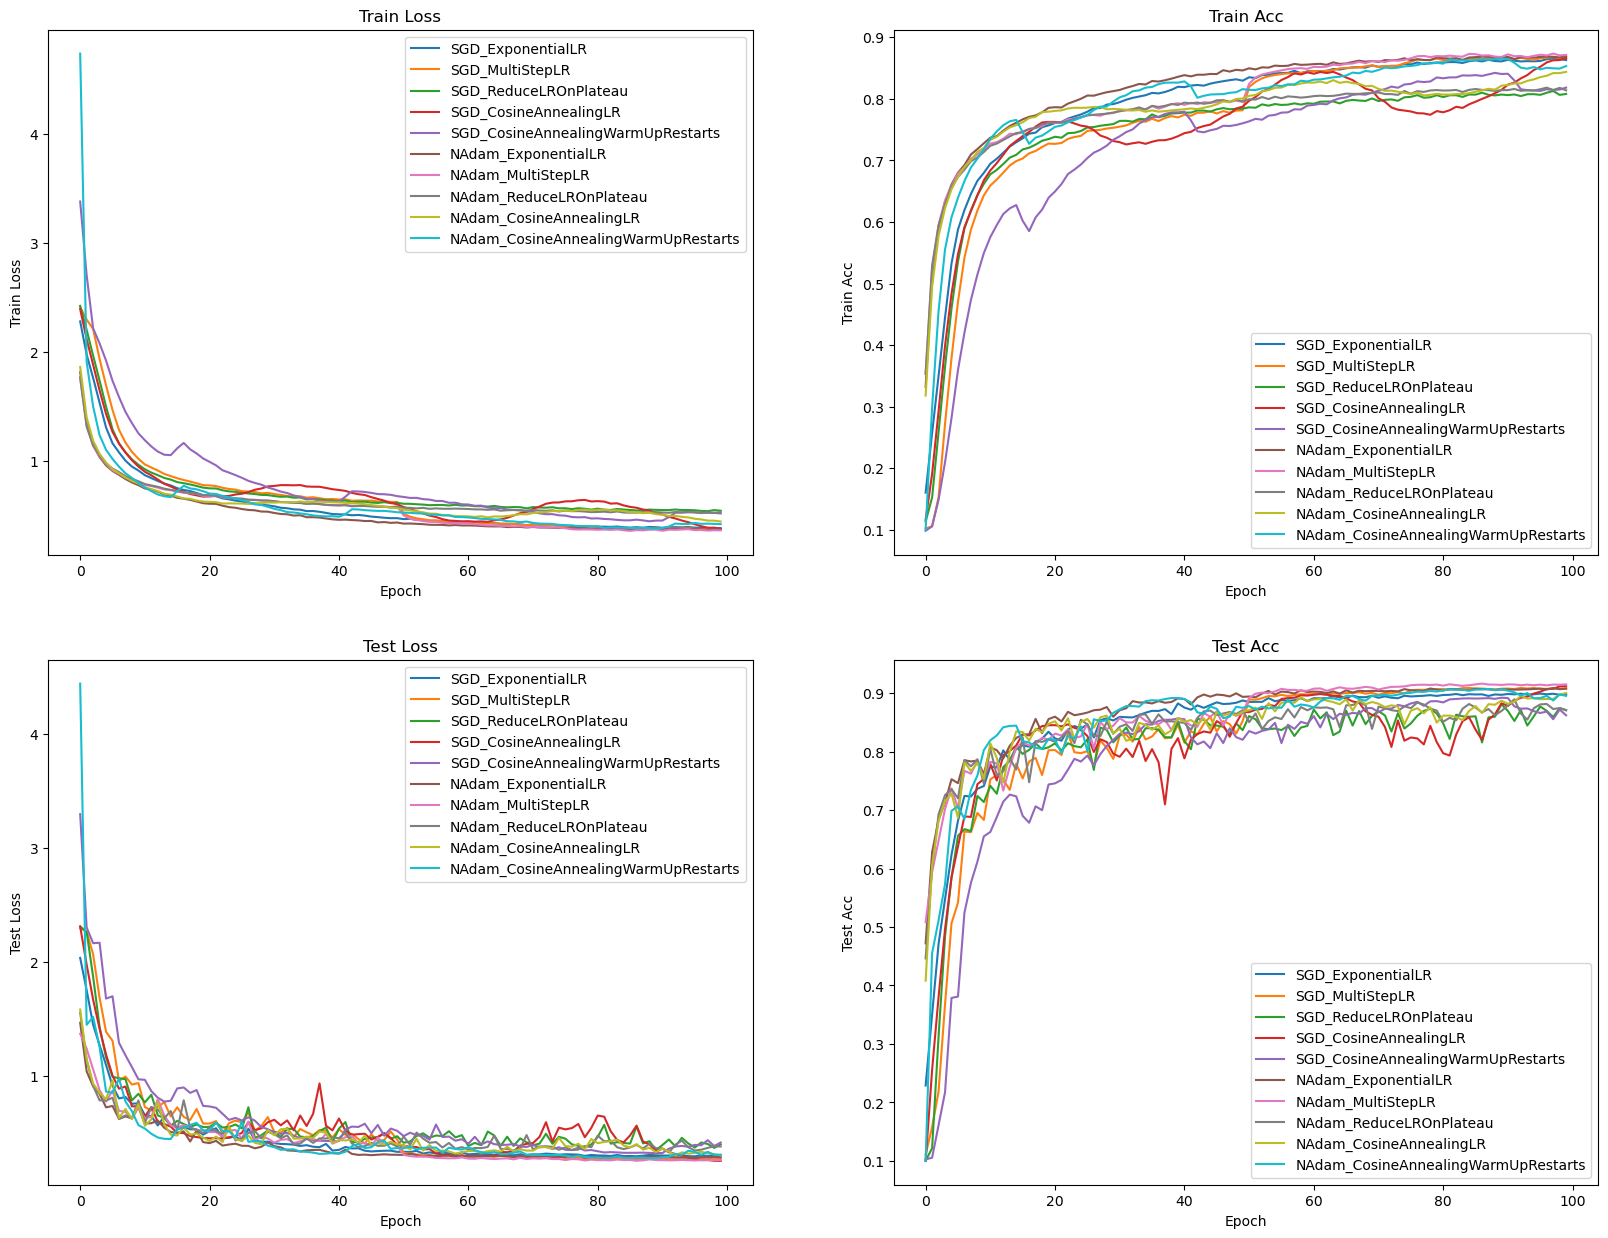

In [43]:
# Create a figure and axis
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(20, 15))

# Plot the train_loss values from each object
for training in each_trainings:
    # ax[0][0].plot(training.logs["train_loss"], label=training.optim_name, linestyle='-', linewidth=2)
    # ax[0][1].plot(training.logs["train_acc"], label=training.optim_name, linestyle='--', linewidth=2)
    # ax[1][0].plot(training.logs["test_loss"], label=training.optim_name, linestyle=':', linewidth=2)
    # ax[1][1].plot(training.logs["test_loss"], label=training.optim_name, linestyle='-.', linewidth=2)
    ax[0][0].plot(training.logs["train_loss"], label=training.optim_name+"_"+training.scheduler_name)
    ax[0][1].plot(training.logs["train_acc"], label=training.optim_name+"_"+training.scheduler_name)
    ax[1][0].plot(training.logs["test_loss"], label=training.optim_name+"_"+training.scheduler_name)
    ax[1][1].plot(training.logs["test_acc"], label=training.optim_name+"_"+training.scheduler_name)

# Set labels and title
ax[0][0].set_xlabel("Epoch")
ax[0][0].set_ylabel("Train Loss")
ax[0][0].set_title("Train Loss")
ax[0][0].legend()

ax[0][1].set_xlabel("Epoch")
ax[0][1].set_ylabel("Train Acc")
ax[0][1].set_title("Train Acc")
ax[0][1].legend()

ax[1][0].set_xlabel("Epoch")
ax[1][0].set_ylabel("Test Loss")
ax[1][0].set_title("Test Loss")
ax[1][0].legend()

ax[1][1].set_xlabel("Epoch")
ax[1][1].set_ylabel("Test Acc")
ax[1][1].set_title("Test Acc")
ax[1][1].legend()

# Add a legend


# Show the plot
plt.show()

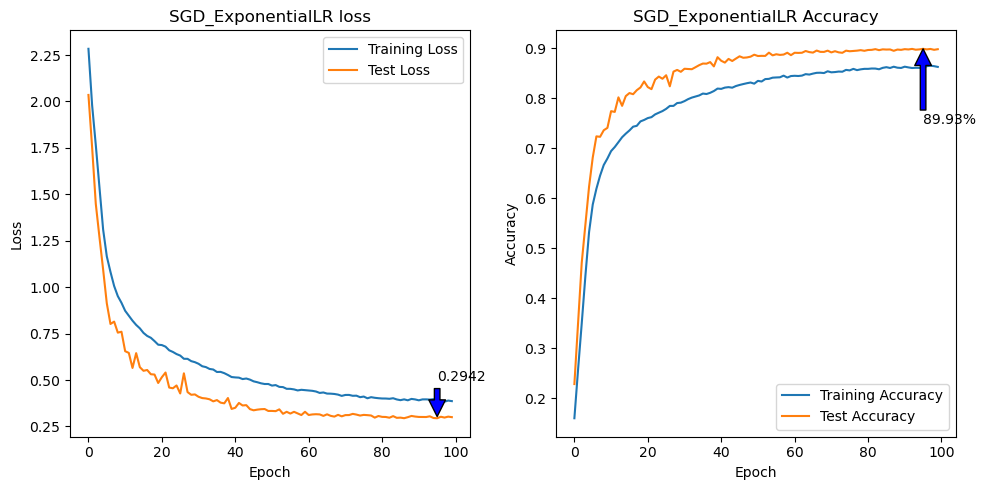

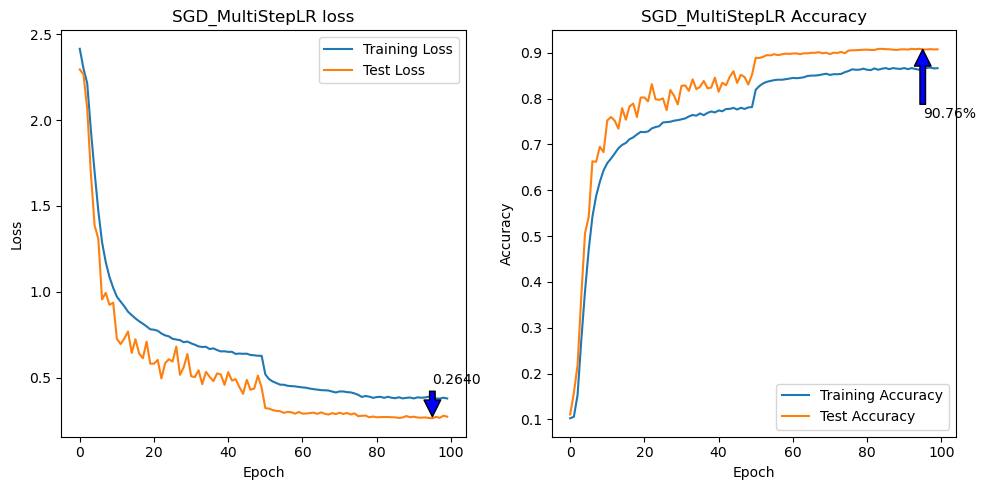

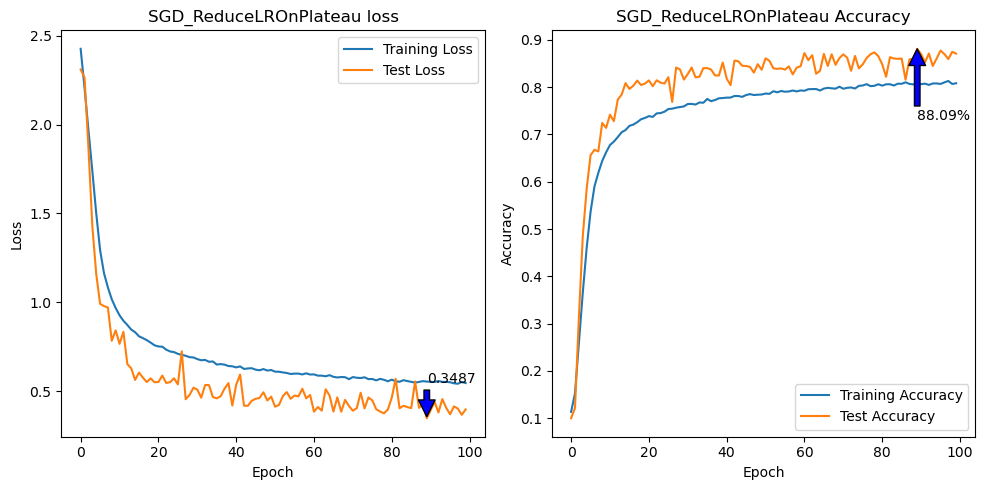

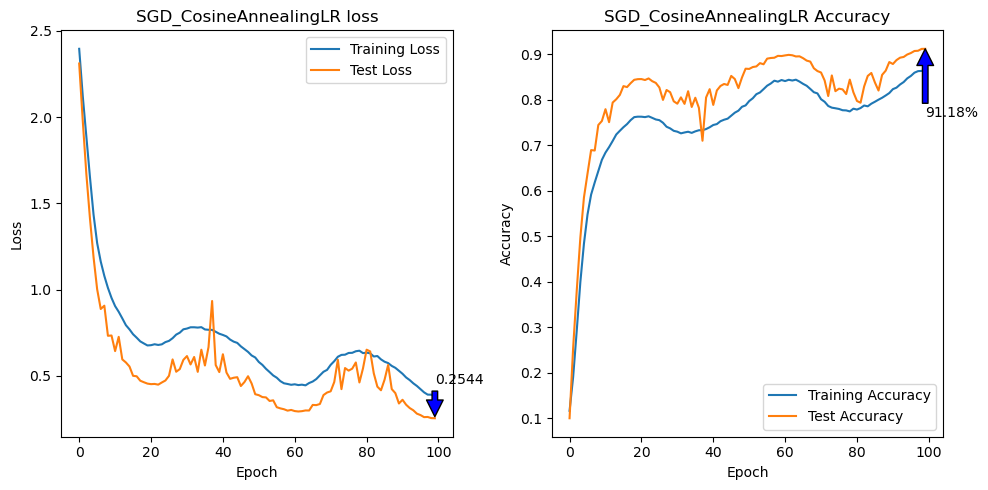

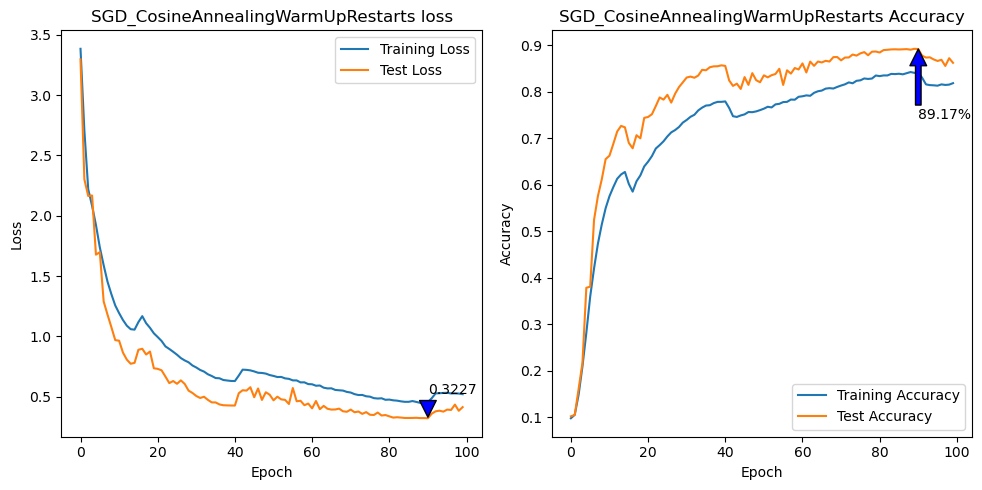

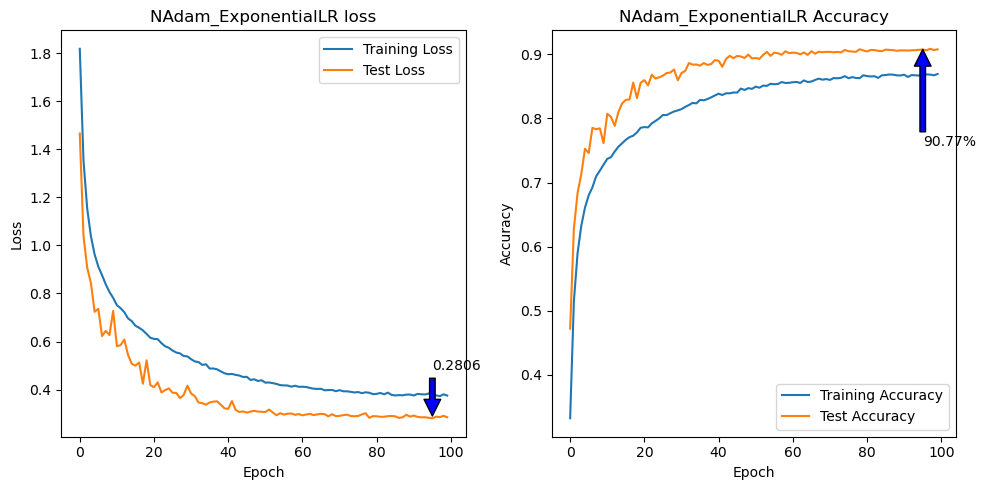

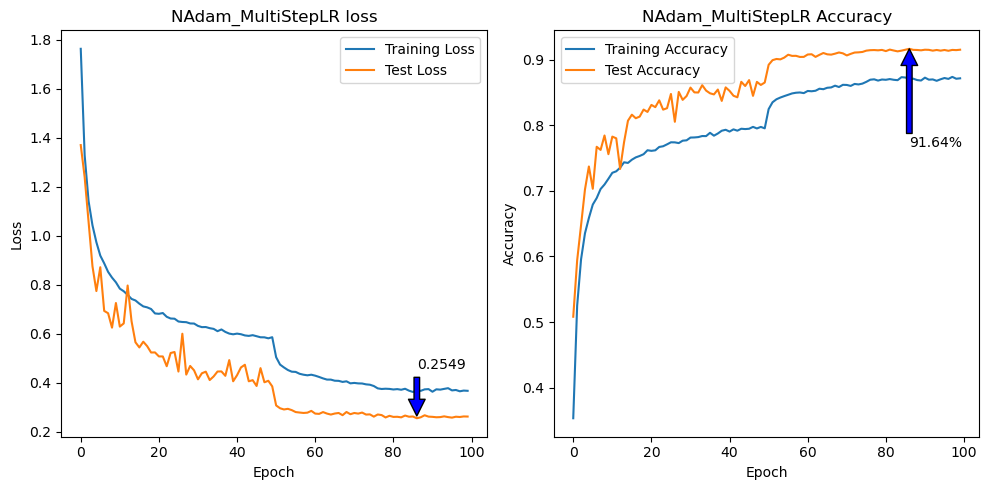

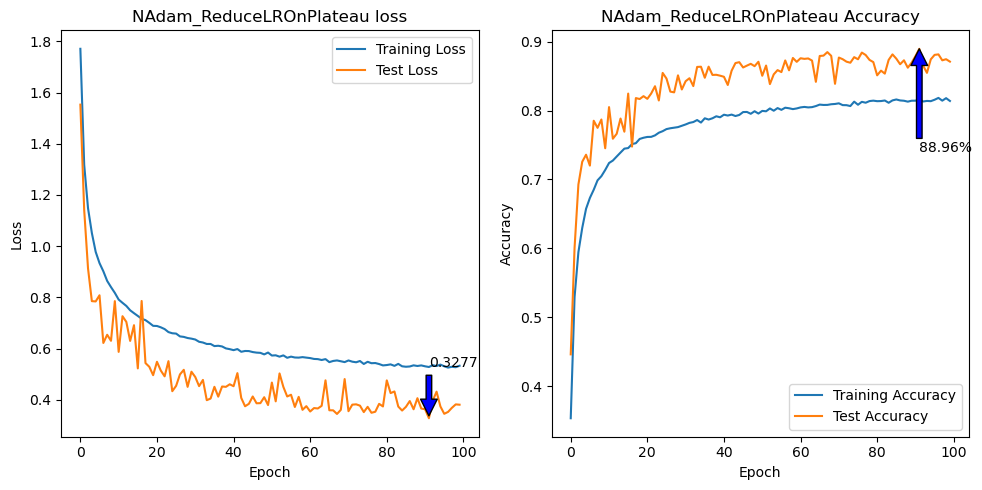

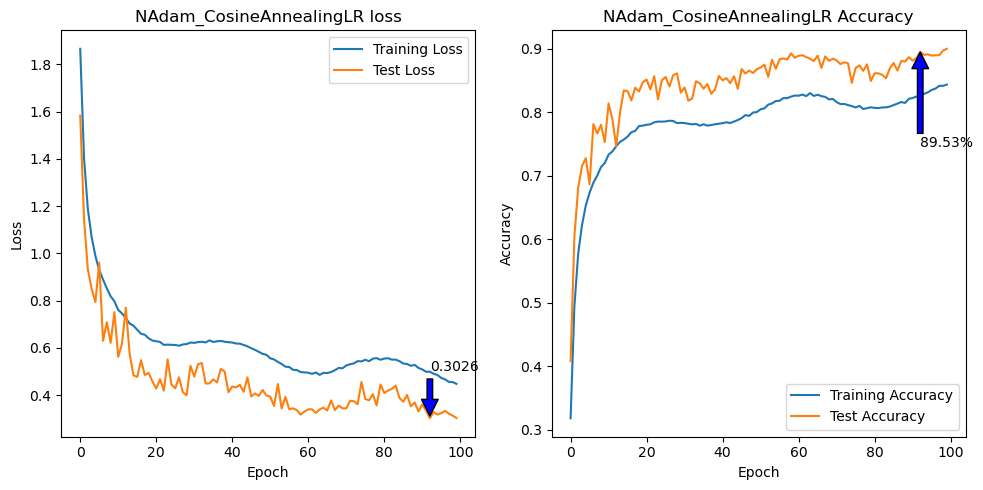

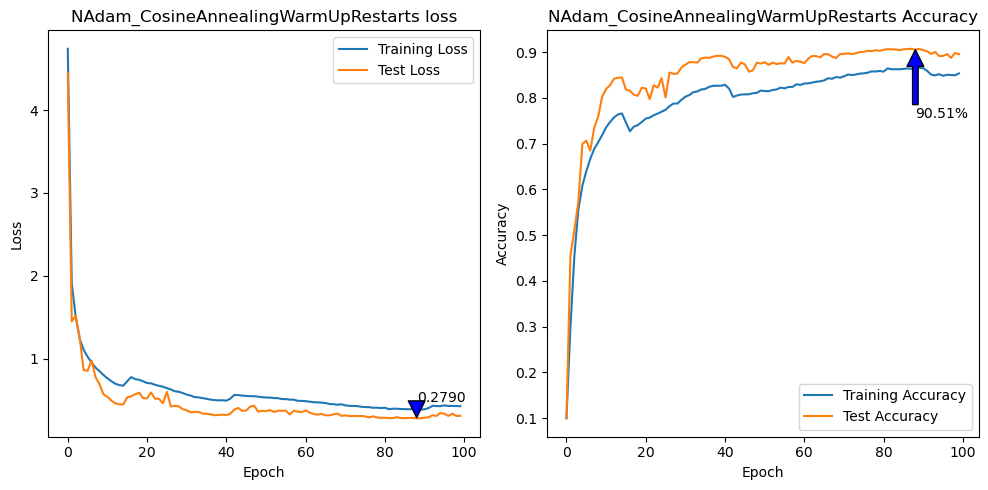

In [44]:
for training in each_trainings:
    viewer = LogViewer(training.logs)
    viewer.draw(
        title=training.optim_name + "_" + training.scheduler_name, min_marker=True, save=True
    )